In [3]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
import ctypes
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

## Feature extraction from image files

In [ ]:
metadata_root_path = '/kaggle/input/spinal-canal-stenosis-metadata'

for file in os.listdir(metadata_root_path):
    labels = []
    features = []
    data = {}
    metadata_file_path = os.path.join(metadata_root_path, file)
    print(metadata_file_path)
    metadata_df = pl.read_csv(metadata_file_path, low_memory=True)
    for j in tqdm(range(metadata_df.shape[0])):
        dcm_image_path = metadata_df.item(j,0)
        dicom_ds = dcmread(dcm_image_path)
        img_array = dicom_ds.pixel_array
        features.append(np.mean(img_array.T, axis=0))
        # features.append(dcmread(dcm_image_path).pixel_array)
        labels.append(metadata_df.item(j,2))

    print("feature list length --> ", len(features))
    print("label list length --> ", len(labels))

    #extracted_training_features = np.array([np.resize(img,(128,128)) for img in features])
    #training_labels = np.array(labels)

    #del labels
    #del features
    #gc.collect()

    extracted_training_features_file_name = "{0}_training_features".format(file.replace('_feature_metadata.csv',''))
    labels_file_name = "{0}_labels".format(file.replace('.csv',''))

    with open(extracted_training_features_file_name, "wb") as file:
        pickle.dump(features, file)
    with open(labels_file_name, "wb") as file:
        pickle.dump(labels, file)

    del labels
    del features
    gc.collect()
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)

    #data["image_array"] = features
    #data["encoded_severity"] = labels
    #extracted_training_data = pd.DataFrame(data)
    #extracted_training_data.to_csv("{0}.csv.gz".format(file.replace('.csv','')), index=False, compression='gzip')

    print('finished dumping features & labels for {0}'.format(file))

/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l5_s1_feature_metadata.csv


 51%|█████     | 74401/147131 [30:01<54:35, 22.21it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 147131/147131 [59:20<00:00, 41.33it/s]  


feature list length -->  147131
label list length -->  147131
finished dumping features & labels for <_io.BufferedWriter name='spinal_canal_stenosis_l5_s1_feature_metadata_labels'>
/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l3_l4_feature_metadata.csv


 79%|███████▉  | 116665/147131 [44:46<10:58, 46.25it/s]  

In [4]:
metadata_root_path = '/kaggle/input/spinal-canal-stenosis-metadata'

list_ds = tf.data.Dataset.list_files(str(metadata_root_path+'/*'))

In [6]:
for f in list_ds:
  print(f)

tf.Tensor(b'/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l4_l5_feature_metadata.csv', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l1_l2_feature_metadata.csv', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l3_l4_feature_metadata.csv', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l5_s1_feature_metadata.csv', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l2_l3_feature_metadata.csv', shape=(), dtype=string)


In [5]:
image_bytes \
= tf.io.read_file('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/1.dcm')

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

W: DcmMetaInfo: No Group Length available in Meta Information Header


In [11]:
image.shape

TensorShape([1, 320, 320, 1])

In [12]:
image_resized = tf.image.resize(image, [128,128])
image_resized.shape

TensorShape([1, 128, 128, 1])

In [28]:
def read_and_parse_dicom_files(full_file_path, label):
    image_bytes = tf.io.read_file(full_file_path)
    image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
    image_resized = tf.image.resize(image, [128,128])
    return image_resized, label

In [26]:
metadata_file_path = '/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l1_l2_feature_metadata.csv'
metadata_df = pl.read_csv(metadata_file_path, low_memory=True)
image_filenames = pl.Series(metadata_df.select(pl.col('full_img_path'))).to_list()
image_labels = pl.Series(metadata_df.select(pl.col('encoded_severity'))).to_list()

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, image_labels))
dataset = dataset.map(read_and_parse_dicom_files)

In [30]:
test = dataset.batch(5)

In [33]:
for image_batch, labels_batch in test:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(5, 1, 128, 128, 1)
(5,)


W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header


In [34]:
from tensorflow.keras.applications import EfficientNetB0

conv_base = EfficientNetB0(include_top=False, weights=None, input_shape=(128,128,1))
model = conv_base.output
model = (tf.keras.layers.Flatten(input_shape=[128]))(model)
model = (tf.keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.LecunNormal(seed=None)))(model)
model = (tf.keras.layers.Dense(250, activation="relu"))(model)
model = (tf.keras.layers.Dense(200, activation="selu"))(model)
model = (tf.keras.layers.Dense(100, activation="selu"))(model)
model = (tf.keras.layers.Dense(80, activation="selu"))(model)
model = (tf.keras.layers.Dense(3, activation="softmax"))(model)
model = tf.keras.models.Model(conv_base.input, model)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"], steps_per_execution=32)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
train_ds, test_val_ds = tf.keras.utils.split_dataset(dataset, left_size=0.70)
test_ds, val_ds = tf.keras.utils.split_dataset(test_val_ds, left_size=0.80)

W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length av

KeyboardInterrupt: 

In [38]:
labeled_all_length = [i for i,_ in enumerate(dataset)][-1] + 1

train_size = int(0.7 * labeled_all_length)
val_test_size = int(0.2 * labeled_all_length)

df_train = dataset.take(train_size)
df_test = dataset.skip(train_size)
df_val = df_test.skip(val_test_size)
df_test = df_test.take(val_test_size)

df_train_length = [i for i,_ in enumerate(df_train)][-1] + 1
df_val_length = [i for i,_ in enumerate(df_val)][-1] + 1
df_test_length = [i for i,_ in enumerate(df_test)][-1] + 1

print('Original: ', labeled_all_length)
print('Train: ', df_train_length)
print('Validation :', df_val_length)
print('Test :', df_test_length)

W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length av

KeyboardInterrupt: 

In [ ]:
history = model.fit(x_train, y_train, epochs=110, validation_data=(x_valid, y_valid))

In [25]:
metadata_df.head(5)

full_img_path,severity,encoded_severity
str,str,i64
"""/kaggle/input/rsna-2024-lumbar…","""Normal/Mild""",1
"""/kaggle/input/rsna-2024-lumbar…","""Normal/Mild""",1
"""/kaggle/input/rsna-2024-lumbar…","""Normal/Mild""",1
"""/kaggle/input/rsna-2024-lumbar…","""Normal/Mild""",1
"""/kaggle/input/rsna-2024-lumbar…","""Normal/Mild""",1


In [15]:
cropped_image = tf.image.resize_with_crop_or_pad(image, 100, 100)

Text(0.5, 1.0, 'image')

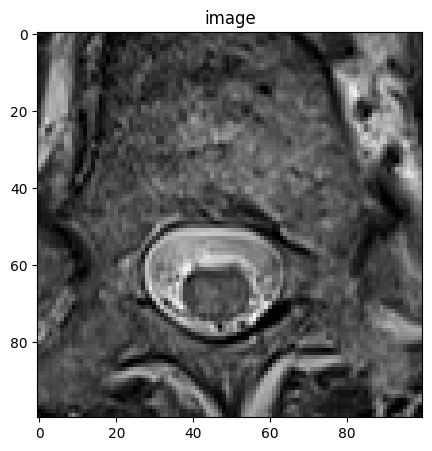

In [16]:
fig, axes = plt.subplots(1,1, figsize=(5,5))
axes.imshow(np.squeeze(cropped_image.numpy()), cmap='gray')
axes.set_title('image')